In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report  #混淆矩阵
from sklearn import metrics

from sklearn import metrics
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import dgl
import torch



#mpl.rcParams['font.sans-serif'] = ['FangSong']SimHei
# plt.rcParams['font.sans-serif'] = ['FangSong']	# 显示中文
# plt.rcParams['axes.unicode_minus'] = False		# 显示负号

# 创建预测图目录
import os  
# 获取当前工作目录  
# 判断imgs文件夹是否存在 保存结果图片 
imgs_path = './model'
if not os.path.exists(imgs_path):  
    # 如果不存在，则创建imgs文件夹  
    os.makedirs(imgs_path)  
    
# 设置随机种子为固定值，这里设为0
torch.manual_seed(42)

图的边的特征列名

In [2]:
edge_f = ['Duration', 'FlowBytesSent', 'FlowSentRate',
       'FlowBytesReceived', 'FlowReceivedRate', 'PacketLengthVariance',
       'PacketLengthStandardDeviation', 'PacketLengthMean',
       'PacketLengthMedian', 'PacketLengthMode', 'PacketLengthSkewFromMedian',
       'PacketLengthSkewFromMode', 'PacketLengthCoefficientofVariation',
       'PacketTimeVariance', 'PacketTimeStandardDeviation', 'PacketTimeMean',
       'PacketTimeMedian', 'PacketTimeMode', 'PacketTimeSkewFromMedian',
       'PacketTimeSkewFromMode', 'PacketTimeCoefficientofVariation',
       'ResponseTimeTimeVariance', 'ResponseTimeTimeStandardDeviation',
       'ResponseTimeTimeMean', 'ResponseTimeTimeMedian',
       'ResponseTimeTimeMode', 'ResponseTimeTimeSkewFromMedian',
       'ResponseTimeTimeSkewFromMode',
       'ResponseTimeTimeCoefficientofVariation']

读取两种数据

In [3]:
benign = pd.read_csv('l2-benign.csv')

In [4]:
malicious = pd.read_csv('l2-malicious.csv')

标签标注：良性：0  恶性：1

In [5]:
benign['Label'] = 0
malicious['Label'] = 1

数据合并 去除空值  随机筛选2万条数据进行训练和测试

In [6]:
df = pd.concat([benign,malicious]).dropna()

设置随机抽取数据集数量

In [7]:
sample = 3000

In [8]:
# 筛选标签为0的数据  
df_label_0 = df[df['Label'] == 0]   
# 筛选标签为1的数据  
df_label_1 = df[df['Label'] == 1]  
# 从标签为0的数据中随机取sample条  
sample_0 = df_label_0.sample(n=sample, random_state=42)  # 设置random_state以确保结果的可复现性  
# 从标签为1的数据中随机取sample条  
sample_1 = df_label_1.sample(n=sample, random_state=42)  
# 合并样本作为训练集  
data = pd.concat([sample_0, sample_1])  
# 如果需要，保存训练集到CSV文件  
data.to_csv(f'train_set_{sample}.csv', index=False)

In [9]:
data.shape

(6000, 35)

In [10]:
data.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
8512,192.168.20.111,8.8.8.8,47458,443,2019/12/16 19:32,0.195289,4468,22878.912790,6084,31153.828430,...,0.417545,7.260540e-05,0.008521,0.009222,0.008136,0.000039,0.382191,1.077651,0.924020,0
13762,192.168.20.111,9.9.9.9,40246,443,2019/12/19 23:34,0.125645,2351,18711.448920,4472,35592.343510,...,0.518810,6.056590e-05,0.007782,0.007827,0.007811,0.015544,0.005879,-0.991627,0.994335,0
10124,192.168.20.111,8.8.8.8,49038,443,2019/12/10 1:28,118.016134,513,4.346863,381,3.228372,...,0.922606,3.070000e-10,0.000018,0.015483,0.015473,0.015469,1.769584,0.818195,0.001131,0
2635,192.168.20.111,8.8.8.8,37502,443,2019/12/13 18:05,0.015491,171,11038.667610,105,6778.129236,...,0.707107,0.000000e+00,0.000000,0.015477,0.015477,0.015477,-10.000000,-10.000000,0.000000,0
16230,192.168.20.113,176.103.130.130,41924,443,2019/12/19 19:36,0.021905,128,5843.414745,74,3378.224150,...,0.707107,0.000000e+00,0.000000,0.021895,0.021895,0.021895,-10.000000,-10.000000,0.000000,0


In [11]:
data.isna().sum()

SourceIP                                  0
DestinationIP                             0
SourcePort                                0
DestinationPort                           0
TimeStamp                                 0
Duration                                  0
FlowBytesSent                             0
FlowSentRate                              0
FlowBytesReceived                         0
FlowReceivedRate                          0
PacketLengthVariance                      0
PacketLengthStandardDeviation             0
PacketLengthMean                          0
PacketLengthMedian                        0
PacketLengthMode                          0
PacketLengthSkewFromMedian                0
PacketLengthSkewFromMode                  0
PacketLengthCoefficientofVariation        0
PacketTimeVariance                        0
PacketTimeStandardDeviation               0
PacketTimeMean                            0
PacketTimeMedian                          0
PacketTimeMode                  

In [12]:
pd.set_option('display.float_format',lambda x:'{:.3f}'.format(x))    #控制输出为精确到小数点后三位
color = sns.color_palette()
sns.set_style('darkgrid')

目标和特征热力图

C:\Users\tojoy\AppData\Local\Temp\ipykernel_43464\1090798881.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = data.corr()
C:\Users\tojoy\AppData\Local\Temp\ipykernel_43464\1090798881.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(corrmat,rotation='horizontal')


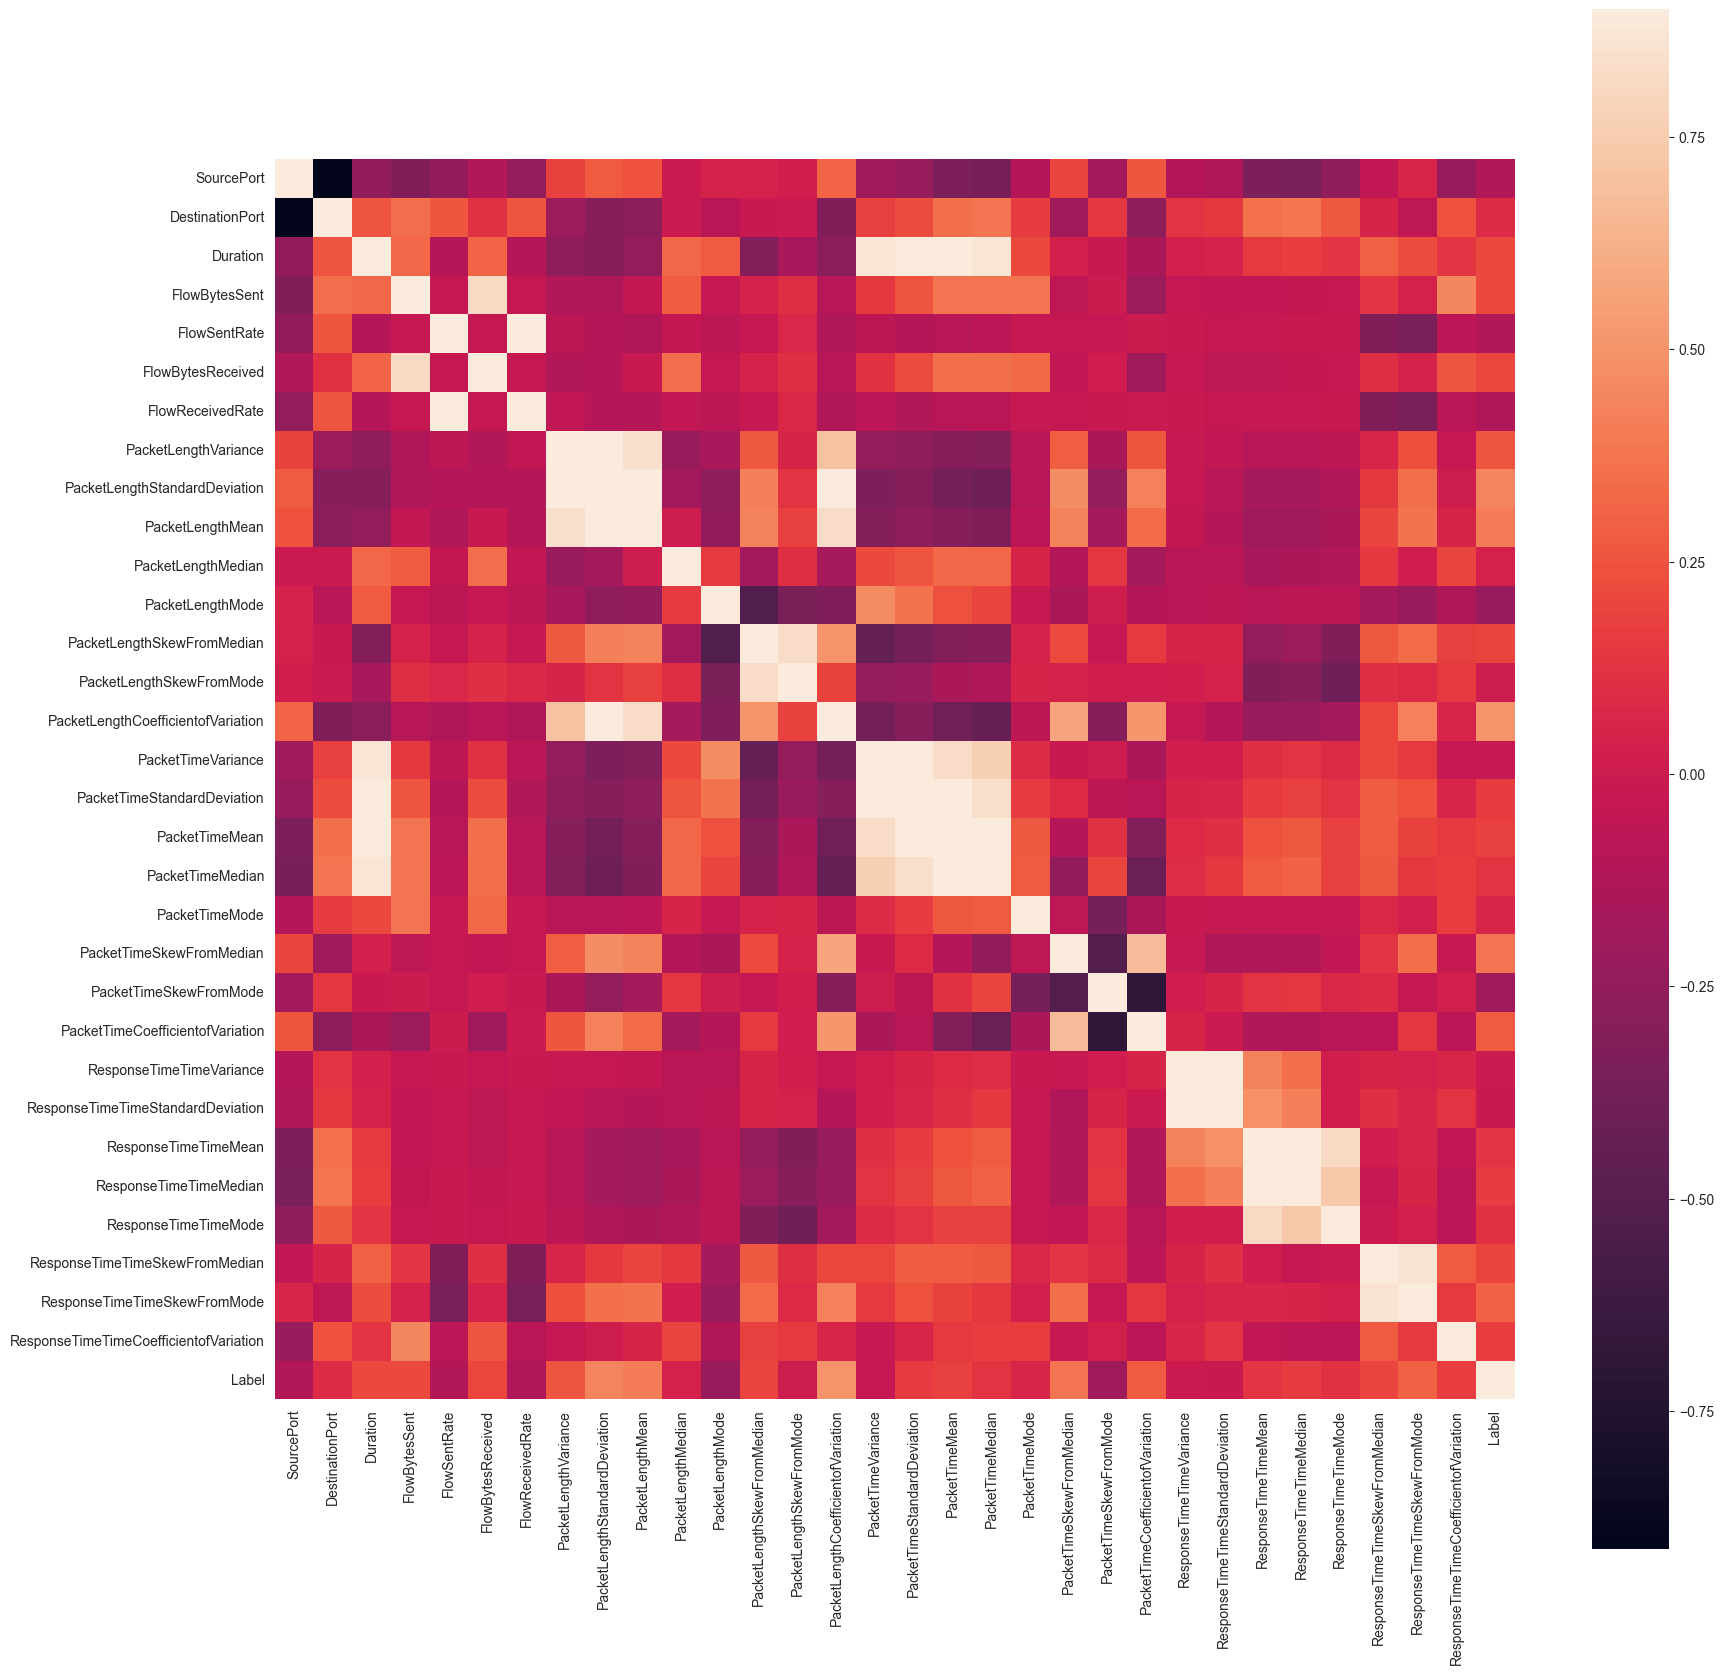

In [13]:
corrmat = data.corr()
f,ax = plt.subplots(figsize=(20,20))
ax.set_xticklabels(corrmat,rotation='horizontal')
sns.heatmap(corrmat, vmax =0.9,square=True)
label_y = ax.get_yticklabels()
plt.setp(label_y , rotation = 360)
label_x = ax.get_xticklabels()
plt.setp(label_x , rotation = 90)
plt.show();

边特征标准化 消除量纲影响

In [14]:
scaler = StandardScaler()
scaler.fit(data[edge_f])
data[edge_f] = scaler.transform(data[edge_f])

生成节点字符串

In [15]:
data['src'] = data['SourceIP']+ '.'+data['SourcePort'].astype(str)

In [16]:
data['dst'] = data['DestinationIP']+ '.'+data['DestinationPort'].astype(str)

合并所有发送和接收节点

In [17]:
nodes = list(set(data['src'].tolist() + data['dst'].tolist()))

In [18]:
nodes[-10:]

['192.168.20.211.48316',
 '192.168.20.111.58818',
 '192.168.20.111.43826',
 '192.168.20.212.60710',
 '192.168.20.204.34794',
 '192.168.20.111.42556',
 '192.168.20.211.33454',
 '192.168.20.144.56720',
 '192.168.20.144.53452',
 '192.168.20.111.44172']

节点特征：使用IP和PORT作为节点特征值

In [19]:
nodes_df = pd.DataFrame(nodes,columns=['node'])

In [20]:
nodes_df_split = nodes_df['node'].str.split('.', expand=True)

In [21]:
node_feature = pd.concat([nodes_df,nodes_df_split],axis=1)

In [22]:
node_feature['id'] = node_feature.index

In [23]:
node_feature.head()

,node,0,1,2,3,4,id
0,192.168.20.204.55634,192,168,20,204,55634,0
1,192.168.20.144.57656,192,168,20,144,57656,1
2,192.168.20.111.34750,192,168,20,111,34750,2
3,192.168.20.144.53334,192,168,20,144,53334,3
4,192.168.20.144.55618,192,168,20,144,55618,4


节点特征标准化

In [24]:
scaler1 = StandardScaler()
scaler1.fit(node_feature[[0,1,2,3,4]])  # data为待标准化的数据
node_feature[[0,1,2,3,4]] = scaler1.transform(node_feature[[0,1,2,3,4]])

边的数量

In [25]:
len(data[['src','dst']].drop_duplicates())

5437

补齐节点序号，以便输入模型处理

In [26]:
data = data.drop_duplicates(subset=['src','dst'])

In [27]:
data = pd.merge(data,node_feature[['node','id']],left_on='src',right_on='node')

In [28]:
data = pd.merge(data,node_feature[['node','id']],left_on='dst',right_on='node')

In [29]:
data[data['FlowBytesSent']==0]

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label,src,dst,node_x,id_x,node_y,id_y


构建图网络模型

In [30]:
src = data['id_x'].values
dst = data['id_y'].values

In [31]:
src = torch.tensor(src,dtype=torch.long)
dst = torch.tensor(dst,dtype=torch.long)

In [32]:
edge_pred_graph = dgl.graph((src, dst))

In [33]:
# 建立点和边特征，以及边的标签
edge_pred_graph.ndata['feature'] = torch.tensor(node_feature[[0,1,2,3,4]].values,dtype=torch.float)
edge_pred_graph.edata['feature'] = torch.tensor(data[edge_f].values,dtype=torch.float)
edge_pred_graph.edata['label'] = torch.tensor(data['Label'].values)
# 进行训练、验证和测试集划分
edge_pred_graph.edata['train_mask'] = torch.zeros(len(src), dtype=torch.bool).bernoulli(0.8)

In [34]:
node_feats = torch.tensor(node_feature[[0,1,2,3,4]].values,dtype=torch.float)
edge_feats = torch.tensor(data[edge_f].values,dtype=torch.float)
edge_labels = torch.tensor(data['Label'].values)
train_mask = torch.zeros(len(src), dtype=torch.bool).bernoulli(0.8)
test_mask = ~train_mask

实验内容：   
节点特征和边特征使用全连接层FC映射到同样的维度

In [35]:
from dgl.nn import RelGraphConv

In [36]:
class EarlyStopping():
    def __init__(self,patience=7,verbose=False,delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
    def __call__(self,val_loss,model,path):
        #print("val_loss={}".format(val_loss))
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss,model,path)
        elif score < self.best_score+self.delta:
            self.counter+=1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter>=self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss,model,path)
            self.counter = 0
    def save_checkpoint(self,val_loss,model,path):
        if self.verbose:
            print(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path+'/'+f'model_checkpoint_{sample}.pth')
        self.val_loss_min = val_loss

In [37]:
class EdgeClassifier(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats, hidden_size, out_size):
        super(EdgeClassifier, self).__init__()
        self.node_embedding = nn.Linear(in_node_feats, hidden_size) # ----  MLP
        self.edge_embedding = nn.Linear(in_edge_feats, hidden_size) # ----  MLP
        self.rel_graph_conv = RelGraphConv(hidden_size, hidden_size, num_rels=1)
        self.classifier = nn.Linear(hidden_size * 3, out_size)  # 考虑到节点和边的组合特征

    def forward(self, g, node_feats, edge_feats):
        # 节点嵌入
        h_nodes = F.relu(self.node_embedding(node_feats))

        # 边嵌入
        h_edges = F.relu(self.edge_embedding(edge_feats))

        # 使用DGL的RelGraphConv进行消息传递
        g.ndata['feature'] = h_nodes
        g.edata['feature'] = h_edges
        g.apply_edges(lambda edges: {'feature': torch.cat([edges.src['feature'], edges.dst['feature'], edges.data['feature']], dim=1)})
        h_edges = g.edata['feature']

        # 分类器
        #h_edges = F.relu(self.rel_graph_conv(g, h_edges))
        edge_preds = self.classifier(h_edges)

        return edge_preds

定义交叉熵损失

In [38]:
criterion = nn.CrossEntropyLoss()

训练模型，输出损失值loss

In [39]:
early_stopping = EarlyStopping(patience=10,verbose=False)

In [40]:
loss_list = []
val_loss_list = []

acc = []
val_acc = []

epoch = 150
edge_label = edge_pred_graph.edata['label']
model = EdgeClassifier(5, 29, 64, 2)
opt = torch.optim.Adam(model.parameters())
for epoch in range(1,epoch+2):
    outputs = model(edge_pred_graph, node_feats, edge_feats)
    outputs_max = np.argmax(outputs[train_mask].detach().numpy(), axis=1)
    labels_max = edge_label[train_mask].detach().numpy()
    total_number = 0
    correct_number = 0
    for i in range(len(outputs_max)):
        if outputs_max[i] == labels_max[i]:
            correct_number += 1
        total_number += 1
    acc.append(correct_number/total_number)
    
    loss = criterion(outputs[train_mask], edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    
    model.eval()
    val_outputs = model(edge_pred_graph, node_feats, edge_feats)
    val_outputs_max = np.argmax(val_outputs[test_mask].detach().numpy(), axis=1)
    val_labels_max = edge_label[test_mask].detach().numpy()
    val_total_number = 0
    val_correct_number = 0

    for i in range(len(val_outputs_max)):
        if val_outputs_max[i] == val_labels_max[i]:
            val_correct_number += 1
        val_total_number += 1
    val_acc.append(val_correct_number/val_total_number)
    val_loss = criterion(outputs[test_mask], edge_label[test_mask])
    val_loss_list.append(val_loss.item())
    
    if epoch % 10 == 0:

        print(f'Epoch {epoch} | Train Loss: {loss.item():.4f} Accuracy: {correct_number / total_number:.4f} | Val Loss: {val_loss.item():.4f} Accuracy: {val_correct_number / val_total_number:.4f}')
        
    #==================early stopping======================
    early_stopping(val_loss_list[-1],model=model,path=r'model')
    if early_stopping.early_stop:
        print("Early stopping")
        break

EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
Epoch 10 | Train Loss: 0.6426 Accuracy: 0.5893 | Val Loss: 0.6359 Accuracy: 0.6072
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
Epoch 20 | Train Loss: 0.5564 Accuracy: 0.8211 | Val Loss: 0.5619 Accuracy: 0.8271
EarlyStopping counter: 3 out of 10
Epoch 30 | Train Loss: 0.4652 Accuracy: 0.8412 | Val Loss: 0.4682 Accuracy: 0.8425
Epoch 40 | Train Loss: 0.4058 Accuracy: 0.8534 | Val Loss: 0.4044 Accuracy: 0.8570
Epoch 50 | Train Loss: 0.3570 Accuracy: 0.8698 | Val Loss: 0.3573 Accuracy: 0.8796
Epoch 60 | Train Loss: 0.3192 Accuracy: 0.8788 | Val Loss: 0.3179 Accuracy: 0.8860
Epoch 70 | Train Loss: 0.2887 Accuracy: 0.8904 | Val Loss: 0.2840 Accuracy: 0.8968
Epoch 80 | Train Loss: 0.2636 Accuracy: 0.8998 | Val Loss: 0.2576 Accuracy: 0.9068
Epoch 90 | Train Loss: 0.2427 Accuracy: 0.9077 | Val Loss: 0.2357 Accuracy: 0.9113
Epoch 100 | Train Loss: 0.2247 Accuracy: 0.

In [41]:
epochs = len(loss_list)

绘制Accuracy图

In [42]:
%matplotlib inline

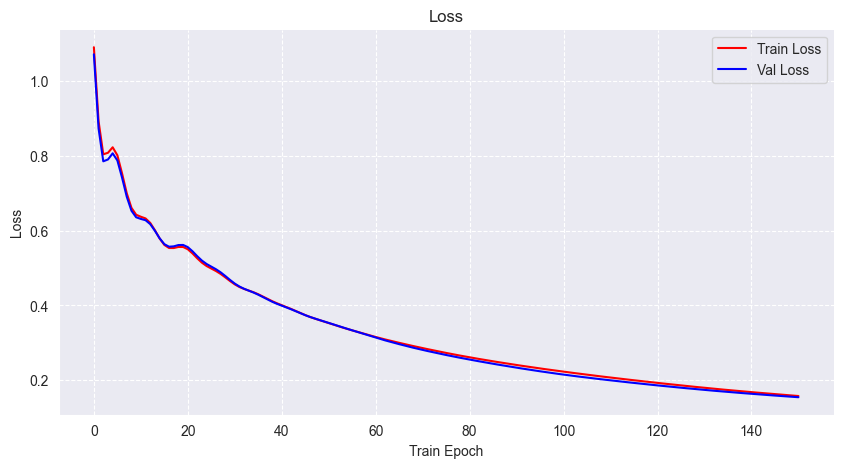

In [43]:
# plt.rcParams['font.sans-serif'] = ['Arial']  # 如果要显示中文字体,则在此处设为：SimHei
# plt.rcParams['axes.unicode_minus'] = False  # 显示负号

plt.figure(figsize=(10, 5))
plt.grid(True, linestyle='--',which='both')  # 设置背景网格线为虚线

ax = plt.gca()
ax.spines['top'].set_visible(False)  # 去掉上边框
ax.spines['right'].set_visible(False)  # 去掉右边框
#ax.set_facecolor("white")

plt.plot(range(epochs), loss_list, label='Train Loss',c='r')
plt.plot(range(epochs), val_loss_list, label='Val Loss',c='b')

plt.title('Loss')
plt.xlabel('Train Epoch')
plt.ylabel('Loss')
plt.legend(loc=1) #第二象项，也就是左上角。 loc可以为1,2,3,4

# leg = plt.gca().get_legend()
# ltext = leg.get_texts()
# plt.setp(ltext, fontsize=12, fontweight='bold')  # 设置图例字体的大小和粗细
plt.savefig('Loss.png')
plt.show();

绘制acc图

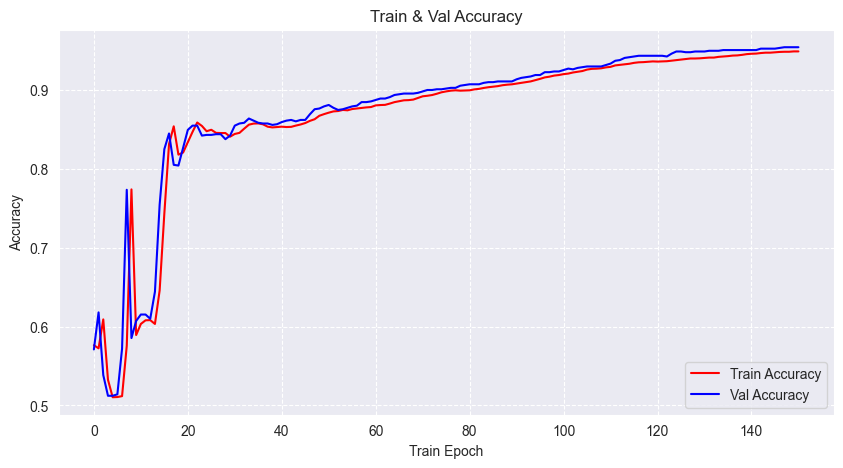

In [44]:
plt.figure(figsize=(10, 5))
plt.grid(True, linestyle='--',which='both')  # 设置背景网格线为虚线

plt.plot(range(epochs), acc, label='Train Accuracy',c='r')
plt.plot(range(epochs), val_acc, label='Val Accuracy',c='b')
plt.title('Train & Val Accuracy')
plt.xlabel('Train Epoch')
plt.ylabel('Accuracy')
plt.savefig('Accuracy.png')
plt.legend(loc=4) #第二象项，也就是左上角。 loc可以为1,2,3,4
plt.show();

In [45]:
#读取
my_model = torch.load(f'model/model_checkpoint_{sample}.pth')
pred = model(edge_pred_graph, node_feats, edge_feats)

In [46]:
torch.set_printoptions(sci_mode=False)

y_pred = torch.argmax(pred[test_mask],axis=1).tolist()
y_test = edge_label[test_mask].tolist()
y_prob = F.softmax(pred[test_mask])[:,1].tolist()

C:\Users\tojoy\AppData\Local\Temp\ipykernel_43464\2418179127.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_prob = F.softmax(pred[test_mask])[:,1].tolist()


In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       505
           1       0.94      0.97      0.96       600

    accuracy                           0.95      1105
   macro avg       0.96      0.95      0.95      1105
weighted avg       0.96      0.95      0.95      1105



In [48]:
# 二分类评价指标
def evaluate(result, test_y, probas, name = 'mymodel'):
    # 1-1 评估指标
    acc = np.mean([result[i] == test_y[i] for i in range(len(result))])
    precision = metrics.precision_score(test_y,result)
    recall = metrics.recall_score(test_y,result)
    f1 = metrics.f1_score(test_y,result)
    #spe = specificity_loss_func(test_y, result)
    print("准确率:",acc.round(4))
    print("精确率:",precision.round(4))
    print("召回率:",recall.round(4))
    
    print("F1:",f1.round(4))

    # 1-2.混淆矩阵
    confusion_mat = confusion_matrix(test_y, result)
    
    tn, fp, fn, tp = confusion_mat.ravel()
    
    # 计算敏感性和特异性
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print("特异度:",round(specificity,4))
    print("敏感度:",round(sensitivity,4))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
    disp.plot(
        include_values=True,            
        cmap=plt.cm.Blues,
        ax=None,                        
        xticks_rotation="horizontal",   
        values_format=".2f"
    )
    plt.title(f"{name} confusion matrix")
    plt.grid(False)
    plt.show();

    # ROC曲线
    roc = metrics.roc_auc_score(test_y,probas)
    print("AUC值:",roc.round(4))
    fpr,tpr,thresholds=metrics.roc_curve(test_y,probas)
    plt.plot(fpr,tpr, label=f"{name} ROC curve (area={round(roc,2)})")
    plt.plot([0,1],[0,1],linestyle='dashed')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} ROC")
    plt.legend(loc='lower right')
    plt.grid(linestyle='-.')  
    plt.grid(True)
    plt.show();
    
    #敏感性特异性曲线
    plt.plot(thresholds, 1-fpr, label='specificity')
    plt.plot(thresholds, tpr, label='sensitivity')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Classification Proportion')
    plt.xlabel('Cutoff')
    plt.legend()
    plt.show()    
    
    # PR曲线
    
    precision,recall,thresholds=metrics.precision_recall_curve(test_y,probas)
    plt.plot(recall,precision,color='y',label=name)
    plt.title(f'{name} Precision-recall curve')
    plt.legend(loc='lower left')
    plt.plot([1,0],[0,1],'r--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.grid(linestyle='-.')  
    plt.grid(True)
    plt.show()
    
    return

准确率: 0.9548
精确率: 0.945
召回率: 0.9733
F1: 0.9589
特异度: 0.9327
敏感度: 0.9733


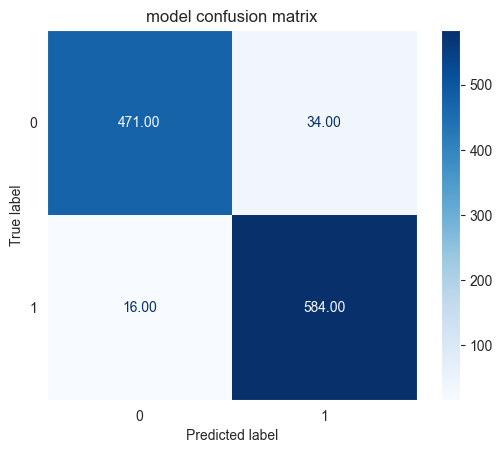

AUC值: 0.9906


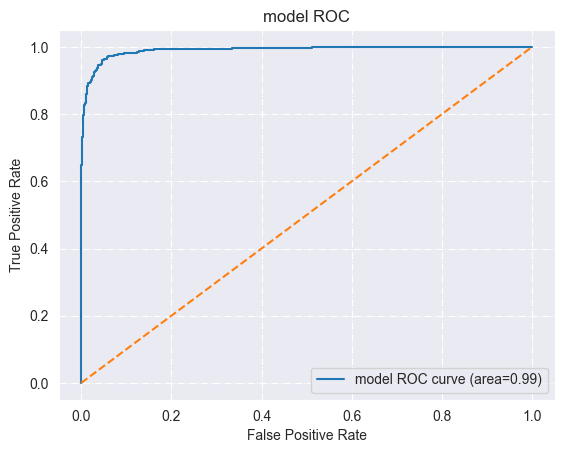

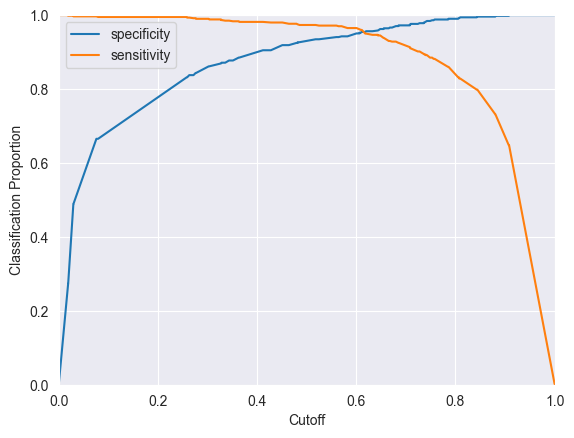

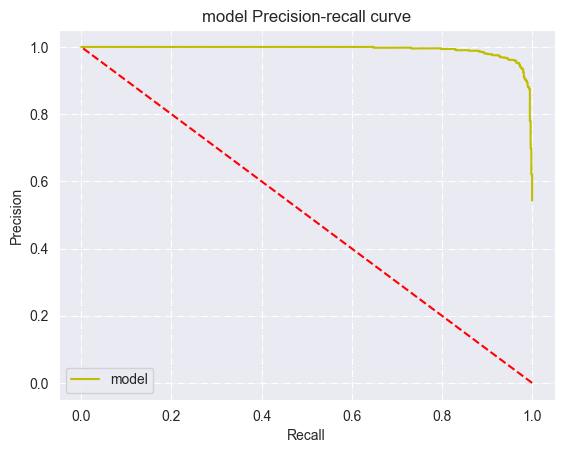

In [49]:
evaluate(y_pred, y_test, y_prob, name = 'model')